# LSTM + SelfAttention
* Daily data

## Imports

In [1]:
import os
import random
import calendar
import datetime
import warnings
import numpy as np
import pandas as pd
from datetime import timedelta
from collections import Counter
from google.cloud import bigquery

from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets

import scipy.stats
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.seasonal import seasonal_decompose

warnings.filterwarnings('ignore')
tqdm.pandas()

In [2]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import timeseries_dataset_from_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm.keras import TqdmCallback

2023-03-27 16:12:26.278960: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-27 16:12:26.346394: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-27 16:12:26.367840: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-27 16:12:26.799351: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

## Config

In [3]:
# Config

PROJECT_ID = 'arpae-prod-ml'

# BigQuery
JOINED_BQ_DATASET = 'JOINED_DATA'
JOINED_DATA_TABLE = "ALL_METEO_FEATS_POL_DAT"
JOINED_WEEK_DATA_TABLE = "ALL_METEO_WEEK_FEATS_POL_DAT"

# Ouput
model_output = "models"

## Methods

In [4]:
# Read Methods

def _run_query(client, query): 
    df = client.query(query).to_dataframe()
    return df

def _create_station_widget(df):
    station_ids = df.station_id.sort_values().unique()
    station_wdgt = widgets.Dropdown(options=station_ids, description='Station Id:', layout={"width":"50%"})
    return station_wdgt

def _create_pol_var_id_widget(df):
    pol_var_ids = df.pol_var_id.sort_values().unique()
    pol_wdgt = widgets.Dropdown(options=pol_var_ids, description='Pol var id:', layout={"width":"50%"})
    return pol_wdgt

def _create_cluster_n_widget(df):
    cluster_ids = df.cluster.sort_values().unique()
    cls_wdgt = widgets.Dropdown(options=cluster_ids, description='Cluster id:', layout={"width":"50%"})
    return cls_wdgt

def min_max_scale(x):
    return (x - x.min()) / (x.max() - x.min())

# 1. Read Data

## 1.1 Config BigQuery

In [5]:
# Setup Client

bq_client = bigquery.Client()
bq_client

## 1.2 Read Tables

In [6]:
# Load B_CODES

sql = f"SELECT * FROM `{PROJECT_ID}.SAMPLE_DATA.B_CODES` WHERE eligible IS true"
b_codes = _run_query(bq_client, sql)

print(b_codes.shape)
b_codes.head(3)

(33, 3)


,var_id,var_descr,eligible
0,B48026,"Mirtacee_Mirtacee indistinte, POLLEN/M**3",True
1,B48006,"Composite_Artemisia, POLLEN/M**3",True
2,B48041,"Spore fungine_Stemphylium, POLLEN/M**3",True


In [7]:
# Load all meteo and pollen data

sql = f"""
    SELECT DISTINCT *
    FROM `{PROJECT_ID}.{JOINED_BQ_DATASET}.{JOINED_DATA_TABLE}`
    WHERE pol_var_id IN {tuple(b_codes.var_id)}
    ORDER BY station_id, pol_var_id, date
"""

raw_df = _run_query(bq_client, sql)

print(raw_df.shape)
raw_df.head(3)

(1362096, 33)


,station_id,date,B13011_min,B13011_max,B13011_mean,B13011_std,B13011_sum,B14198_min,B14198_max,B14198_mean,...,arkimet_id,arkimet_lat,arkimet_lon,meteo_id,pol_var_id,pol_value,modified,pol_var_descr,week,year
0,1,2006-03-01,0.0,0.0,0.0,0.0,0.0,-11.0,588.0,138.76,...,Bologna urbana,44.5008,11.3288,01421,B48001,0.0,1,"Graminacee_Graminacee indistinte, POLLEN/M**3",9,2006
1,1,2006-03-02,0.0,0.0,0.0,0.0,0.0,-6.0,351.0,61.56,...,Bologna urbana,44.5008,11.3288,01421,B48001,0.0,1,"Graminacee_Graminacee indistinte, POLLEN/M**3",9,2006
2,1,2006-03-03,0.0,0.0,0.0,0.0,0.0,-5.0,406.0,87.12,...,Bologna urbana,44.5008,11.3288,01421,B48001,0.0,1,"Graminacee_Graminacee indistinte, POLLEN/M**3",9,2006


## 1.3 Load clustering results

In [8]:
### TSD Clustering
# clusters = pd.read_csv("../data/clusters/clustering_tsd_intervals.csv")

### Station/Specie Clustering
clusters = pd.read_csv("../data/clusters/clustering_intervals.csv")

print(clusters.shape)
clusters.sample(3)

(363, 3)


,station_id,pol_var_id,cluster
159,6,B48037,1
35,2,B48003,9
66,4,B48001,6


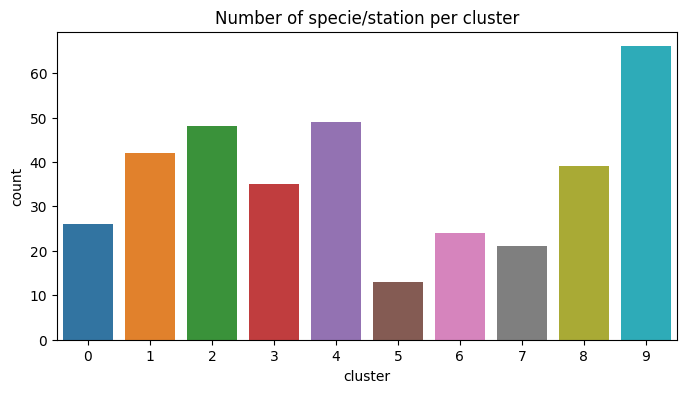

In [9]:
plt.figure(figsize=(8,4))
plt.title("Number of specie/station per cluster")
sns.countplot(x=clusters["cluster"]);

___

# 2. Data preprocess

In [10]:
raw_df.sort_values(["pol_var_id", "date"], inplace=True)

In [11]:
# Convert dates to datetime format
raw_df.date = pd.to_datetime(raw_df.date)

raw_df["month"] = raw_df.date.dt.month
raw_df["week"] = raw_df.date.dt.week

# df["day"] = df.date.dt.day

In [12]:
# Set datetime as index
# raw_df.set_index(["pol_var_id", "station_id", "date"], inplace=True)
raw_df.set_index("date", inplace=True)
raw_df.sort_values(by=['station_id', "pol_var_id", 'date'], ascending=True, inplace=True)

print(raw_df.shape)
raw_df.head(3)

(1362096, 33)


,station_id,B13011_min,B13011_max,B13011_mean,B13011_std,B13011_sum,B14198_min,B14198_max,B14198_mean,B14198_std,...,arkimet_lat,arkimet_lon,meteo_id,pol_var_id,pol_value,modified,pol_var_descr,week,year,month
date,,,,,,,,,,,,,,,,,,,,,
2006-03-01,1,0.0,0.0,0.0,0.0,0.0,-11.0,588.0,138.76,200.669770,...,44.5008,11.3288,01421,B48001,0.0,1,"Graminacee_Graminacee indistinte, POLLEN/M**3",9,2006,3
2006-03-02,1,0.0,0.0,0.0,0.0,0.0,-6.0,351.0,61.56,98.767015,...,44.5008,11.3288,01421,B48001,0.0,1,"Graminacee_Graminacee indistinte, POLLEN/M**3",9,2006,3
2006-03-03,1,0.0,0.0,0.0,0.0,0.0,-5.0,406.0,87.12,133.675702,...,44.5008,11.3288,01421,B48001,0.0,1,"Graminacee_Graminacee indistinte, POLLEN/M**3",9,2006,3


___

# 3. Feature process

## 3.1 Adding Seasonal trend as feature

In [13]:
seasonal_feature = "seasonal"

raw_df[seasonal_feature] = None
for (stat_id, specie_id), specie_data in tqdm(raw_df.groupby(["station_id", "pol_var_id"])):
    
    # Prepare specie data
    specie_data.sort_index(inplace=True)
    specie_pollen = specie_data[["pol_value"]].resample('D').interpolate()
    
    # Evaluate seasonal
    decomposition = seasonal_decompose(specie_pollen, period=365, model='additive')
    specie_seasonal = decomposition.seasonal
    
    # Join seasonal feautre
    mask = ((raw_df.station_id == stat_id) & (raw_df.pol_var_id == specie_id)) # get specie mask
    specie_seasonal = specie_seasonal.reindex(raw_df.loc[mask].index) # reindex due to index diff
    raw_df.loc[mask, seasonal_feature] = specie_seasonal # now we can add the seasonal feature

raw_df.seasonal = raw_df.seasonal.astype(float)
print(raw_df.shape)

  0%|          | 0/363 [00:00<?, ?it/s]

(1362096, 34)


___

# 4. Select data and generate windows

### 4.1 Select Cluster

In [14]:
# Select species/stations from cluster result
def select_cluster_species(df, clusters, cluster_n):
    # Select Cluster pollen ids
    if cluster_n == "all":
        specie_cluster = clusters
    else:
        specie_cluster = clusters[clusters.cluster == cluster_n]
    
    # Select species/stations from cluster result
    df_feature = pd.merge(df.reset_index(), specie_cluster, on=["station_id", "pol_var_id"], how="inner")
    df_feature.station_id = df_feature.station_id.astype(int)
    df_feature.dropna(inplace=True)
    df_feature.set_index("date", inplace=True)

    assert len(specie_cluster) == len(df_feature[["station_id", "pol_var_id"]].drop_duplicates())
    return df_feature

### 4.2 Shift pollen value to predict by one day

In [15]:
def shift_pollen(df):
    ### Applying shift here
    df['pol_value'] = df.groupby(['station_id', 'pol_var_id'])['pol_value'].shift(-1)
    df.dropna(inplace=True)
    return df

### 4.3 Previous days values as feature

In [16]:
def add_previous_values_feat(df, how_many_previous_days, columns_to_shift):
    for shift_n in range(1, how_many_previous_days+1):
        feat_names = [f"{col}_prev_{shift_n}D" for col in columns_to_shift]
        df[feat_names] = df.groupby(['station_id', 'pol_var_id'])[columns_to_shift].shift(+shift_n)

    df.dropna(inplace=True)
    #df.reset_index(drop=True, inplace=True)
    return df

### 4.4 Specie and station are added as a categorical feature to our model

In [17]:
def one_hot_encode_feat(df, columns):
    for col in columns:
        # Encode feature
        var_enc = pd.get_dummies(df[col], prefix=col)
        
        # Add one-hot encoded values to original dataframe
        df = pd.concat([df, var_enc], axis=1)
    return df

### 4.5 Select features

In [18]:
def select_features(df, features, columns_to_shift, columns_to_encode):
    # Add previous pollen day
    for col in columns_to_shift:
        shifted_feature_names = df.keys()[df.keys().str.contains(f"{col}_prev")]
        features.extend(shifted_feature_names.tolist())

    # Add one hot encodings of station and species
    for col in columns_to_encode:
        col_one_hot = df.keys()[df.keys().str.contains(f"{col}_")]
        features.extend(col_one_hot.tolist())

    features = np.array(features)
    return features

### 4.6 Training/test split

In [19]:
def split_group(group):
    # Get group indexes
    group_idxs = group.index.values
    group_len = len(group_idxs)

    # Evaluate indexes for each split
    train_end = int(group_len * training_size)
    test_end = int(group_len * (training_size + test_size))
    val_end = int(group_len * (training_size + test_size + valid_size))
    
    # Selecting splits from indexes
    train_idx = group_idxs[ : train_end]
    test_idx = group_idxs[train_end : test_end]
    val_idx = group_idxs[test_end : ]

    return train_idx, test_idx, val_idx

def train_test_valid_split(df, y_label):
    # Set index back to integers
    df = df.copy()
    df.reset_index(inplace=True)
    
    # Group by station and pollen
    groups = df.groupby(["station_id", "pol_var_id"])

    # Split group indexes
    indexes = groups.apply(split_group).values
    indexes = np.array(indexes)

    # Parse group indexes
    training_idxs = np.hstack([np.sort(idxs[0]) for idxs in indexes])
    test_idxs = np.hstack([np.sort(idxs[1]) for idxs in indexes])
    valid_idxs = np.hstack([np.sort(idxs[2]) for idxs in indexes])

    # Create X, y from dataset
    X = df #[features]
    y = df[[y_label, "date"]]
    
    # Split using indexes
    x_train, y_train = X.loc[training_idxs], y.loc[training_idxs]
    x_test, y_test = X.loc[test_idxs], y.loc[test_idxs]
    x_valid, y_valid = X.loc[valid_idxs], y.loc[valid_idxs]

    x_train.set_index("date", inplace=True)
    y_train.set_index("date", inplace=True)
    x_test.set_index("date", inplace=True)
    y_test.set_index("date", inplace=True)
    x_valid.set_index("date", inplace=True)
    y_valid.set_index("date", inplace=True)

    return x_train, y_train, x_test, y_test, x_valid, y_valid

### 4.7 Create timeseries_dataset_from_array

In [20]:
def create_timeseries_dataset(features, x_train, y_train, x_test, y_test, x_valid, y_valid):
    train_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
        x_train[features],
        y_train,
        sequence_length=window_day_size,
        batch_size=batch_size,
    )

    test_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
        x_test[features],
        y_test,
        sequence_length=window_day_size,
        batch_size=batch_size,
    )

    valid_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
        x_valid[features],
        y_valid,
        sequence_length=window_day_size,
        batch_size=batch_size,
    )
    
    return train_dataset, test_dataset, valid_dataset

___

# 5. Model training

### LSTM, MultiHeadAttention

In [21]:
# def get_model(features_shape):
#     # Define model inputs
#     input_layer = tf.keras.layers.Input(shape=(window_day_size, features_shape))
    
#     lstm_1 = tf.keras.layers.LSTM(units=256, return_sequences=True)(input_layer)

#     ### Multi head attention
#     attn_layer = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=64)(query=lstm_1, value=lstm_1, key=lstm_1)
#     attn_output = tf.keras.layers.Dense(units=64, activation="relu")(attn_layer)

#     # Reshape attention layer
#     att_reshape = tf.keras.layers.Flatten()(attn_output)

#     # Dense layer
#     dense_lst_1 = tf.keras.layers.Dense(units=512)(att_reshape)

#     # Output layer
#     output_layer = tf.keras.layers.Dense(units=1)(dense_lst_1)

#     # Define model architecture
#     model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

#     optimizer = Adam(learning_rate=learning_rate)
#     model.compile(optimizer=optimizer, loss="mse")
#     return model

In [194]:
# def get_model(features_shape):
#     # Define model inputs
#     input_layer = tf.keras.layers.Input(shape=(window_day_size, features_shape))
    
#     # LSTM Layer
#     lstm_1 = tf.keras.layers.LSTM(units=512, dropout=.2, return_sequences=True)(input_layer)
#     lstm_2 = tf.keras.layers.LSTM(units=256, dropout=.2, return_sequences=True)(lstm_1)
#     lstm_3 = tf.keras.layers.LSTM(units=128, dropout=.2, return_sequences=True)(lstm_2)

#     ### Multi head attention
#     attn_layer = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=64)(query=lstm_3, value=lstm_3, key=lstm_3)
#     attn_output = tf.keras.layers.Dense(units=128, activation="relu")(attn_layer)

#     # Reshape attention layer
#     att_reshape = tf.keras.layers.Flatten()(attn_output)

#     # Dense layer
#     dense_lst_1 = tf.keras.layers.Dense(units=128)(att_reshape)
#     dropout_1 = tf.keras.layers.Dropout(.2)(dense_lst_1)
#     dense_lst_2 = tf.keras.layers.Dense(units=64)(dropout_1)
#     dropout_2 = tf.keras.layers.Dropout(.2)(dense_lst_2)
#     dense_lst_3 = tf.keras.layers.Dense(units=32)(dropout_2)

#     # Output layer
#     output_layer = tf.keras.layers.Dense(units=1)(dense_lst_3)

#     # Define model architecture
#     model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

#     # Optimizer
#     optimizer = Adam(learning_rate=learning_rate)
#     #lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(0.001, decay_steps=100, decay_rate=1, staircase=False)
#     #optimizer = Adam(learning_rate=lr_schedule)
    
#     model.compile(optimizer=optimizer, loss="mse")
#     return model

# def get_model(features_shape):
#     # Define model inputs
#     input_layer = tf.keras.layers.Input(shape=(window_day_size, features_shape))

#     ### Multi head attention
#     attn_layer = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=64)(query=input_layer, value=input_layer, key=input_layer)
#     attn_output = tf.keras.layers.Dense(units=64, activation="relu")(attn_layer)

#     # Reshape attention layer
#     att_reshape = tf.keras.layers.Flatten()(attn_output)

#     # Dense layer
#     dense_lst_1 = tf.keras.layers.Dense(units=64, activation="relu")(att_reshape)
#     dropout_1 = tf.keras.layers.Dropout(.2)(dense_lst_1)
#     dense_lst_2 = tf.keras.layers.Dense(units=16, activation="relu")(dropout_1)

#     # Output layer
#     output_layer = tf.keras.layers.Dense(units=1)(dense_lst_2)

#     # Define model architecture
#     model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

#     # Optimizer
#     optimizer = Adam(learning_rate=learning_rate)
#     #lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(0.001, decay_steps=100, decay_rate=1, staircase=False)
#     #optimizer = Adam(learning_rate=lr_schedule)
    
#     model.compile(optimizer=optimizer, loss="mse")
#     return model

In [215]:
def get_model(features_shape):
    # Define model inputs
    input_layer = tf.keras.layers.Input(shape=(window_day_size, features_shape))
    
    # LSTM layers
    lstm_1 = tf.keras.layers.LSTM(units=128, return_sequences=True)(input_layer)
    lstm_2 = tf.keras.layers.LSTM(units=64)(lstm_1)

    # Dense layer
    dense_lst_1 = tf.keras.layers.Dense(units=32)(lstm_2)
    dense_lst_2 = tf.keras.layers.Dense(units=16)(dense_lst_1)

    # Output layer
    output_layer = tf.keras.layers.Dense(units=1)(dense_lst_2)

    # Define model architecture
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

    # Define optimizer
    #optimizer = Adam(learning_rate=learning_rate)
    #model.compile(optimizer=optimizer, loss="mse")
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(delta=huber_delta, name='loss'))
    
    return model

___

# 6. Training Pipeline

In [210]:
def get_processed_data(cluster_n, log=False):
    # Select data from cluster (all if cluster_n is None)
    df_feature = select_cluster_species(raw_df, clusters, cluster_n=cluster_n)
    
    # Shift pollen value to prev day (label)
    df_feature = shift_pollen(df_feature)

    # Add feature previous days values
    df_feature = add_previous_values_feat(df_feature, how_many_previous_days, columns_to_shift)

    # Convert features to one hot encoding
    df_feature = one_hot_encode_feat(df_feature, columns_to_encode)
    
    if log: print("Dataset shape:", df_feature.shape)

    # Select features
    features = [
        "week",
        "seasonal",
        "station_lat", "station_lon",
        "station_H_piano_strada", "station_H_mslm",
        "B13011_min", "B13011_max", "B13011_mean", "B13011_std",
        "B14198_min", "B14198_max", "B14198_mean", "B14198_std",
        "TEMP_min", "TEMP_max", "TEMP_mean", "TEMP_std",
        "PREC"
    ]
    y_label = "pol_value"

    features = select_features(df_feature, features, columns_to_shift, columns_to_encode)
    if log: print(len(features), "features")

    x_train, y_train, x_test, y_test, x_valid, y_valid = train_test_valid_split(df_feature, y_label)
    if log: print(f"x_training_size: {x_train.shape}, x_test_size: {x_test.shape}, x_valid_size: {x_valid.shape}")
    if log: print(f"y_training_size: {y_train.shape}, y_test_size: {y_test.shape}, y_valid_size: {y_valid.shape}")

    ### Verify station/pollen split dates
    # x_train.reset_index().groupby(["station_id","pol_var_id"]).date.agg([min, max]).head()
    # x_test.reset_index().groupby(["station_id","pol_var_id"]).date.agg([min, max]).head()
    # x_valid.reset_index().groupby(["station_id","pol_var_id"]).date.agg([min, max]).head()
    
    train_dataset, test_dataset, valid_dataset = create_timeseries_dataset(features, x_train, y_train, x_test, y_test, x_valid, y_valid)
    
    class dataset:
        pass

    dataset.cluster_n = cluster_n
    dataset.features = features
    dataset.x_train = x_train
    dataset.y_train = y_train
    dataset.x_test = x_test
    dataset.y_test = y_test
    dataset.x_valid = x_valid
    dataset.y_valid = y_valid
    dataset.train_dataset = train_dataset
    dataset.test_dataset = test_dataset
    dataset.valid_dataset = valid_dataset
    return dataset

In [211]:
def train_model(dataset, log=False):
    model_name = f"lstm_self-att_daily_cluster-{dataset.cluster_n}"
    model_output_path = f"{model_output}/{model_name}.h5"
    
    if os.path.exists(model_output_path):
        !rm $model_output_path

    print(f"Training model for cluster: {dataset.cluster_n}. Output folder: {model_output_path}")
    
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(model_output_path, monitor='val_loss', mode='min', save_best_only=True)

    model = get_model(len(dataset.features))
    if log: print(model.summary())

    history = model.fit(
        dataset.train_dataset,
        validation_data=dataset.test_dataset,
        epochs=n_epochs,
        shuffle=True,
        verbose=0,
        callbacks=[early_stop, model_checkpoint, TqdmCallback(verbose=1)]
    )

    # Load the best model
    print("Loading best model")
    model = tf.keras.models.load_model(model_output_path)
    
    return history, model

## 6.1 Params

In [217]:
how_many_previous_days = 7
columns_to_shift = ["pol_value"]#, "PREC", 'TEMP_min', 'TEMP_max', "TEMP_sum"]
columns_to_encode = ["station_id", "pol_var_id"]

training_size, test_size = .9, .05
valid_size = np.round(1 - training_size - test_size, 5)

batch_size = 2048
window_day_size = 7

n_epochs = 100
learning_rate = .001
huber_delta = 1

In [218]:
### Choose clusters for training and test
all_clusters = sorted(clusters.cluster.unique())
# all_clusters.append("all")

# for debugging purpose
all_clusters = random.sample(all_clusters, 2)
all_clusters = [4]

print(f"Training clusters: {all_clusters}")

Training clusters: [4]


## 6.2 Launch training pipeline

In [219]:
trainings = []
for cluster_n in tqdm(all_clusters):

    # Get dataset
    dataset = get_processed_data(cluster_n=cluster_n)

    # Train dataset
    dataset.history, dataset.model = train_model(dataset)

    # Store results
    trainings.append(dataset)

  0%|          | 0/1 [00:00<?, ?it/s]

Training model for cluster: 4. Output folder: models/lstm_self-att_daily_cluster-4.h5


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Restoring model weights from the end of the best epoch: 47.
Epoch 57: early stopping
Loading best model


___

# 8. Results

In [29]:
# ### Load saved models
# results = []
# for dataset in tqdm(trainings):

#     # Get dataset
#     # dataset = get_processed_data(cluster_n=dataset.cluster_n)

#     # Load trained model
#     model_name = f"lstm_self-att_daily_cluster-{dataset.cluster_n}"
#     model_output_path = f"{model_output}/{model_name}.h5"
#     dataset.model = tf.keras.models.load_model(model_output_path)
    
#     # Store results
#     results.append(dataset)

## 8.1 Loss training history

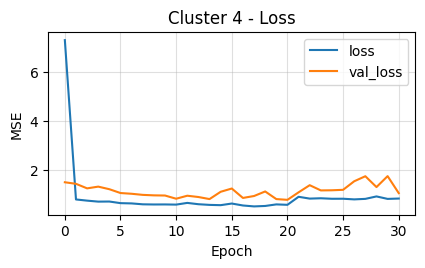

In [200]:
rows, cols = 5, 3
fig, axs = plt.subplots(rows, cols, figsize=(12,12), squeeze=False)
for subpltn, dataset in enumerate(trainings):
    ax = axs[divmod(subpltn, cols)]
    ax.set_title(f"Cluster {dataset.cluster_n} - Loss")
    ax.plot(dataset.history.history['loss'])
    ax.plot(dataset.history.history['val_loss'])
    ax.set_ylabel('MSE')
    ax.set_xlabel('Epoch')
    ax.legend(['loss', 'val_loss'], loc='upper right')
    ax.grid(alpha=.4)
for subpltn in range(subpltn+1, rows*cols): fig.delaxes(axs.flatten()[subpltn]) # removing empty plots from subplot grid
plt.tight_layout()
plt.show();

## 8.2 Models MSE Train/Test/Valid

In [201]:
# cluster_model_mse = []
# for dataset in tqdm(trainings):
#     cluster_model_mse.append({
#         "cluster_n": dataset.cluster_n,
#         "train_mse": dataset.model.evaluate(dataset.train_dataset, verbose=False),
#         "test_mse": dataset.model.evaluate(dataset.test_dataset, verbose=False),
#         "valid_mse": dataset.model.evaluate(dataset.valid_dataset, verbose=False),
#     })
# cluster_model_mse = pd.DataFrame(cluster_model_mse)

# fig, ax = plt.subplots(figsize=(10, 4))
# cluster_model_mse.plot(x='cluster_n', kind='bar', ax=ax)
# ax.set_title('Mean Squared Error vs. Cluster Size')
# ax.set_xlabel('Cluster Size')
# ax.set_ylabel('Mean Squared Error')
# # plt.yscale("symlog")
# plt.grid(alpha=.4)
# plt.show()

## 8.2 Training/Test Model Predictions

In [202]:
# ### Test on training data
# rows, cols = 4, 3
# fig, axs = plt.subplots(rows, cols, figsize=(14,10), squeeze=False)
# for subpltn, dataset in enumerate(trainings):
#     predictions = dataset.model.predict(dataset.train_dataset, verbose=False).squeeze()
#     mse = dataset.model.evaluate(dataset.train_dataset, verbose=False)

#     ax = axs[divmod(subpltn, cols)]
#     ax.set_title(f"Cluster {dataset.cluster_n} - Training preditcions - MSE: {np.round(mse, 2)}")
#     ax.scatter(dataset.y_train.index, dataset.y_train.values, s=3, c="green", label="pol_value true")
#     ax.scatter(dataset.y_train.index[window_day_size-1:], predictions, s=3, c="red", label="pol_value predicted")
#     ax.set_ylabel('Pollen')
#     ax.set_xlabel('Date')
#     ax.grid(alpha=.4)

# for subpltn in range(subpltn+1, rows*cols): fig.delaxes(axs.flatten()[subpltn]) # removing empty plots from subplot grid
# plt.tight_layout()
# plt.show();

In [203]:
# ### Test on test data
# rows, cols = 4, 3
# fig, axs = plt.subplots(rows, cols, figsize=(14,10), squeeze=False)
# for subpltn, dataset in enumerate(trainings):
#     predictions = dataset.model.predict(dataset.test_dataset, verbose=False).squeeze()
#     mse = dataset.model.evaluate(dataset.test_dataset, verbose=False)

#     ax = axs[divmod(subpltn, cols)]
#     ax.set_title(f"Cluster {dataset.cluster_n} - Test preditcions - MSE: {np.round(mse, 2)}")
#     ax.scatter(dataset.y_test.index, dataset.y_test.values, s=3, c="green", label="pol_value true")
#     ax.scatter(dataset.y_test.index[window_day_size-1:], predictions, s=3, c="red", label="pol_value predicted")
#     ax.set_ylabel('Pollen')
#     ax.set_xlabel('Date')
#     ax.grid(alpha=.4)

# for subpltn in range(subpltn+1, rows*cols): fig.delaxes(axs.flatten()[subpltn]) # removing empty plots from subplot grid
# plt.tight_layout()
# plt.show();

# Validation data

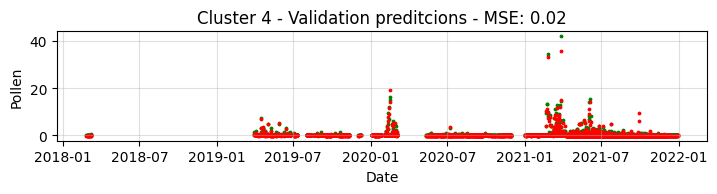

In [220]:
### Test on validation data
rows, cols = 6, 2
fig, axs = plt.subplots(rows, cols, figsize=(14,10), squeeze=False)
for subpltn, dataset in enumerate(trainings):
    predictions = dataset.model.predict(dataset.valid_dataset, verbose=False).squeeze()
    mse = dataset.model.evaluate(dataset.valid_dataset, verbose=False)

    ax = axs[divmod(subpltn, cols)]
    ax.set_title(f"Cluster {dataset.cluster_n} - Validation preditcions - MSE: {np.round(mse, 2)}")

    ax.scatter(dataset.y_valid.index[:-window_day_size+1], dataset.y_valid[:-window_day_size+1].values, s=3, c="green", label="pol_value true")
    ax.scatter(dataset.y_valid.index[:-window_day_size+1], predictions, s=3, c="red", label="pol_value predicted")

    ax.set_ylabel('Pollen')
    ax.set_xlabel('Date')
    ax.grid(alpha=.4)

for subpltn in range(subpltn+1, rows*cols): fig.delaxes(axs.flatten()[subpltn]) # removing empty plots from subplot grid
plt.tight_layout()
plt.show();

# Validation data - Single cluster, all specie/pollen

In [205]:
cluster_wgt = _create_cluster_n_widget(clusters)
display(cluster_wgt)

Dropdown(description='Cluster id:', layout=Layout(width='50%'), options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=…

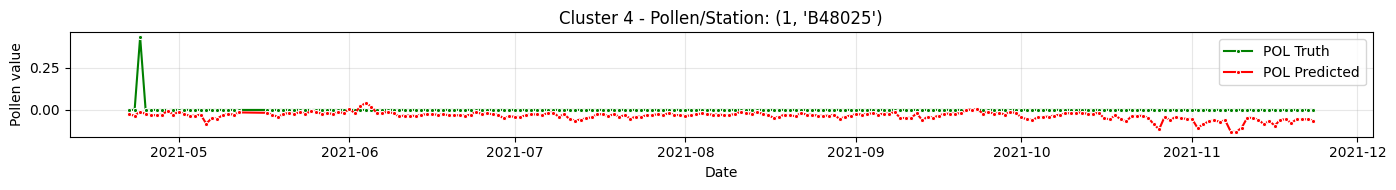

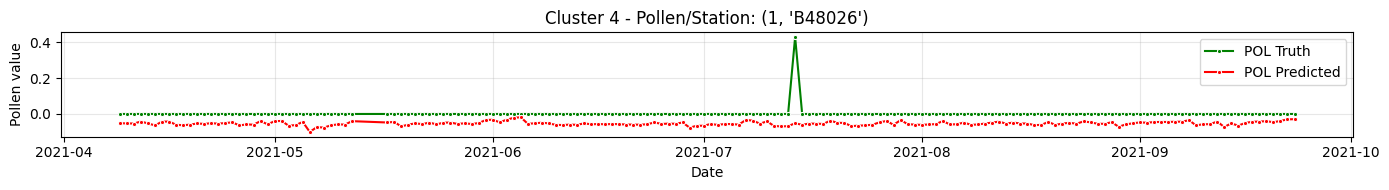

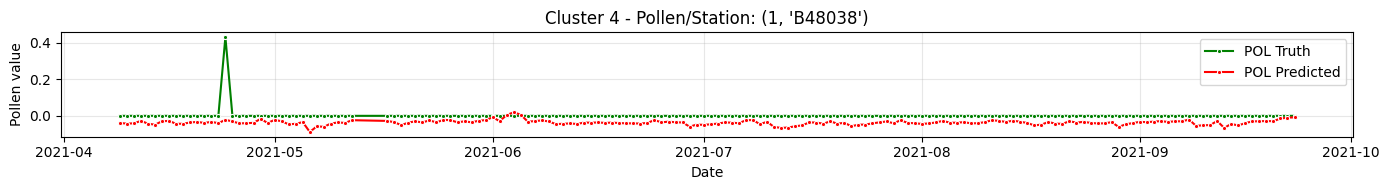

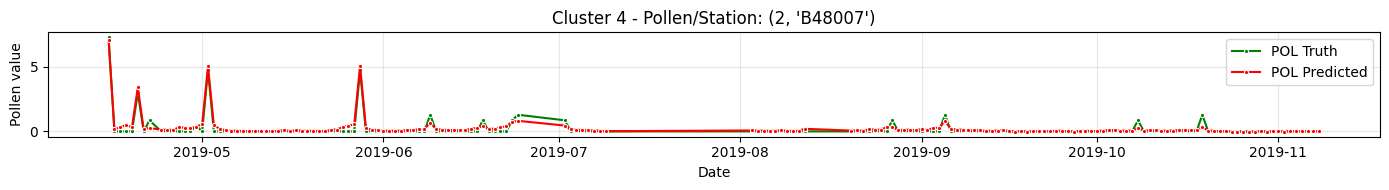

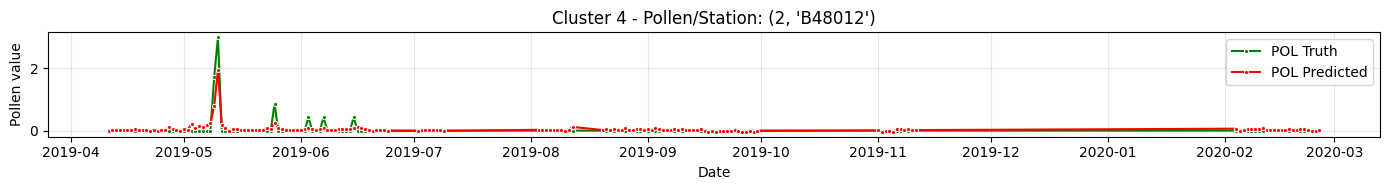

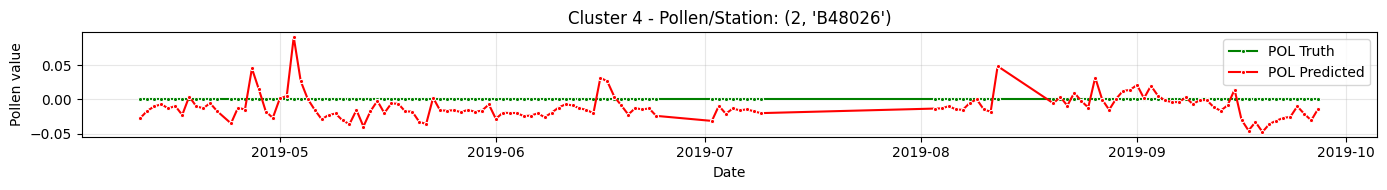

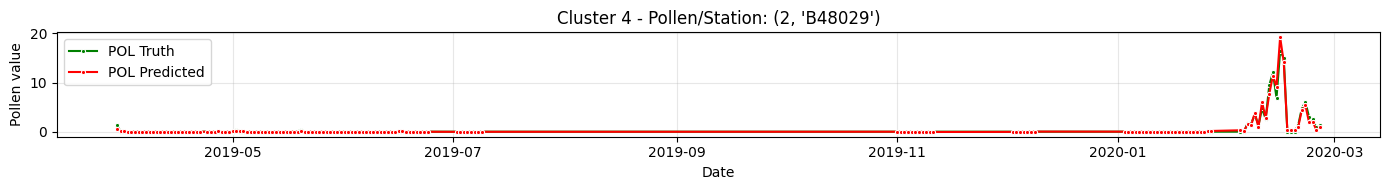

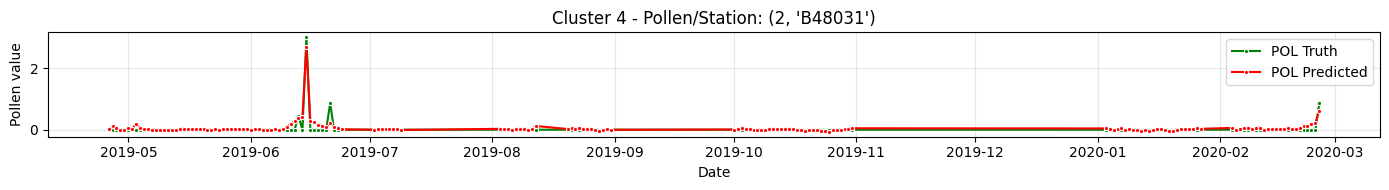

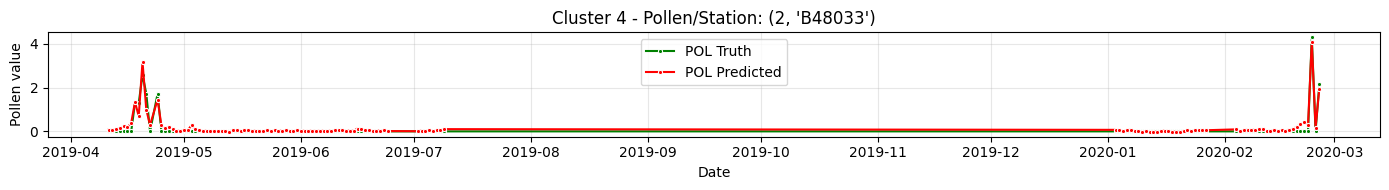

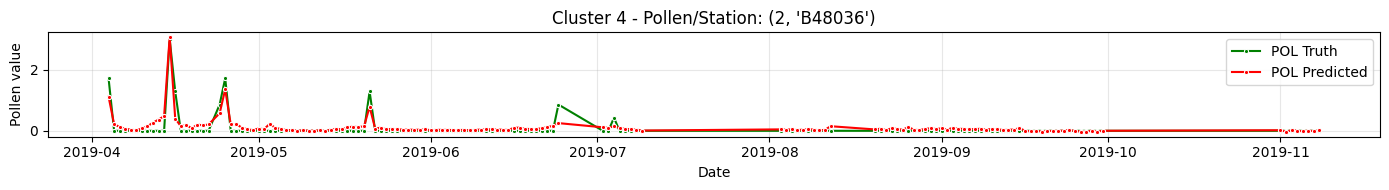

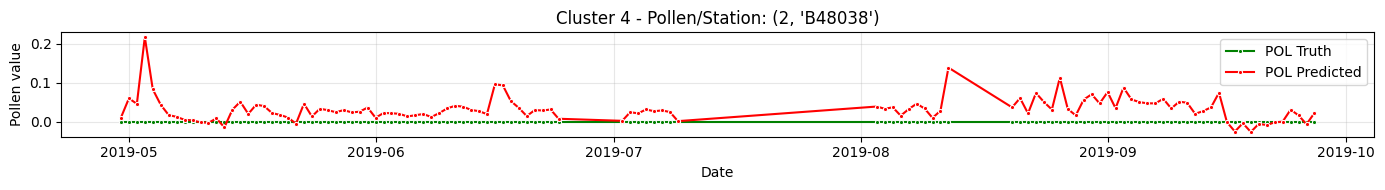

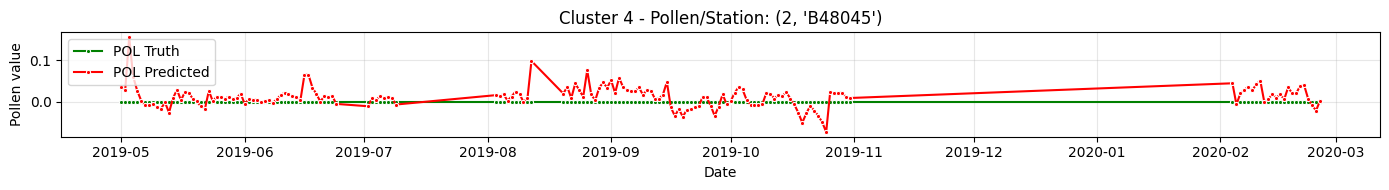

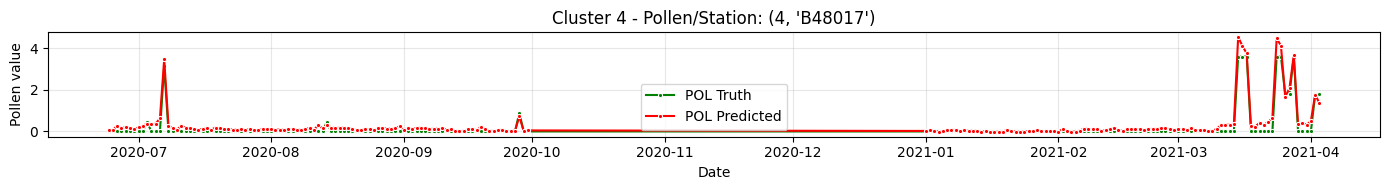

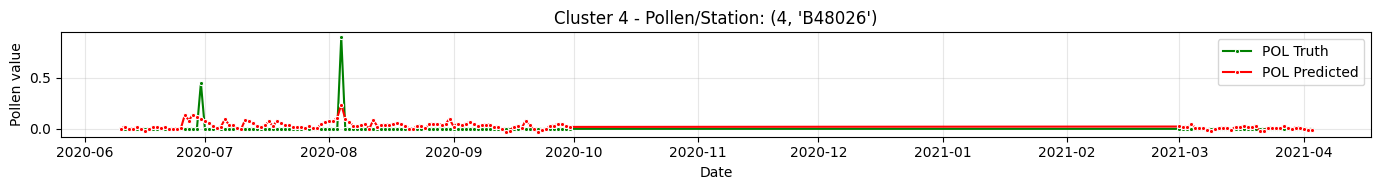

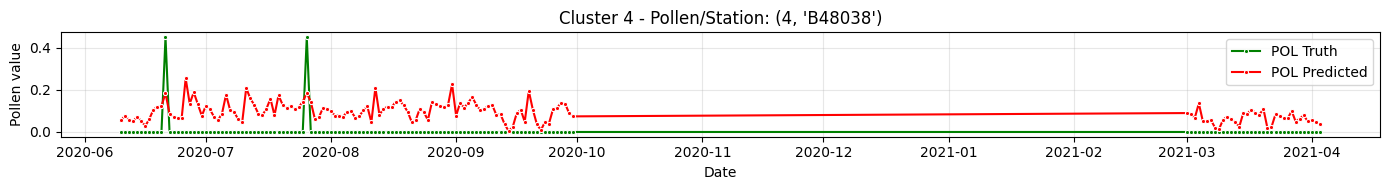

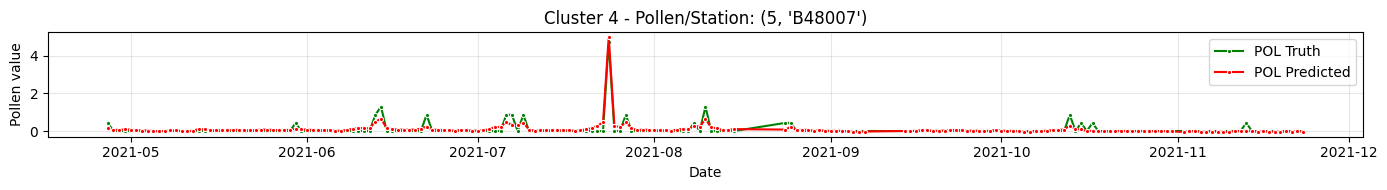

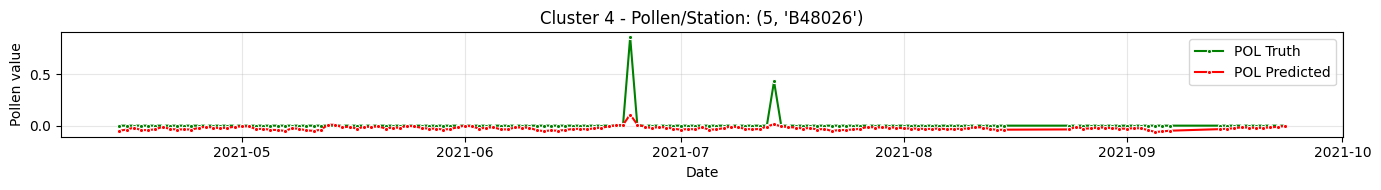

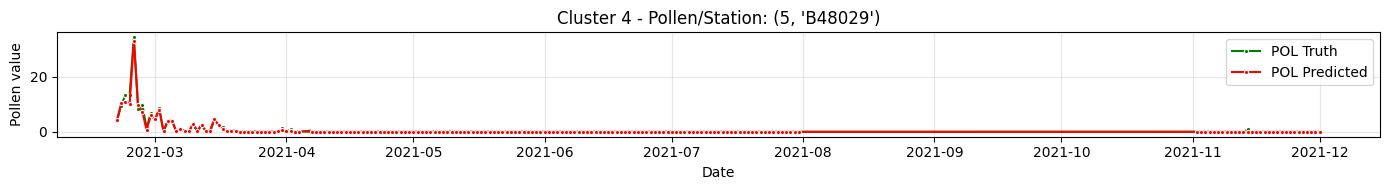

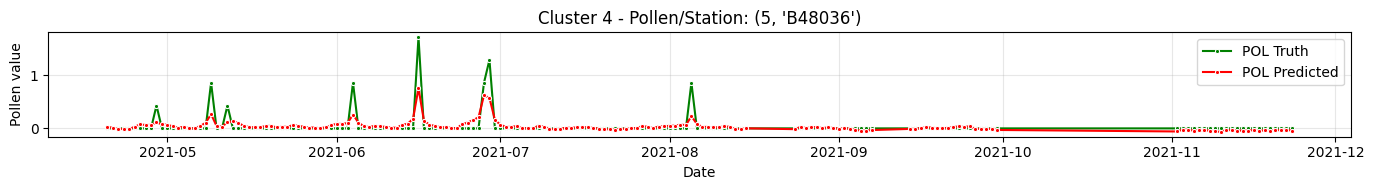

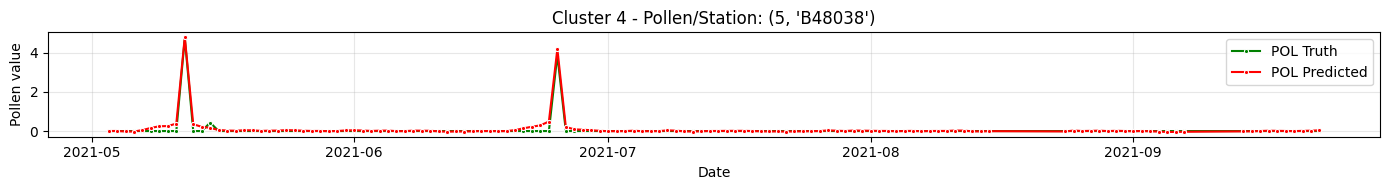

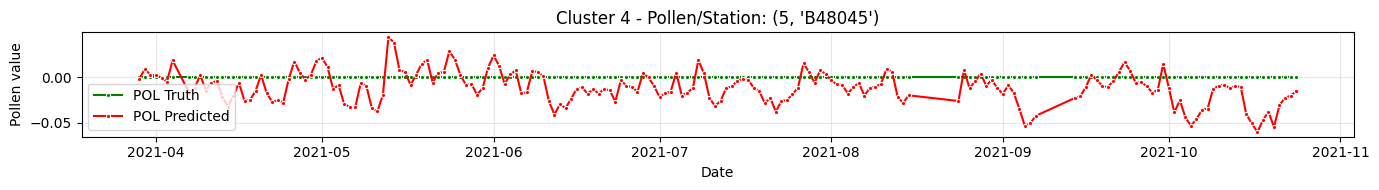

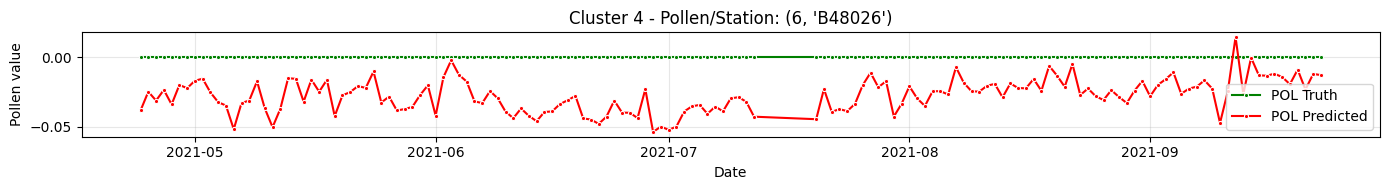

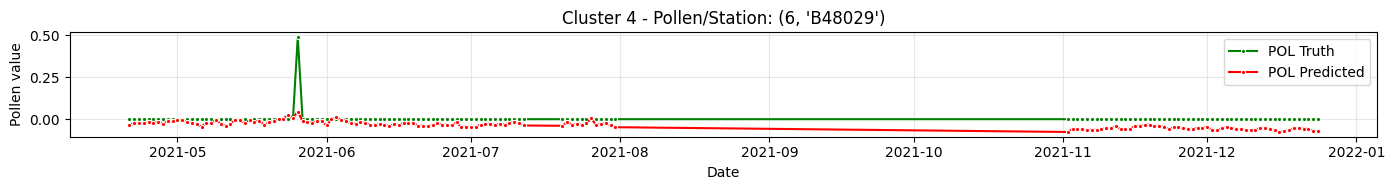

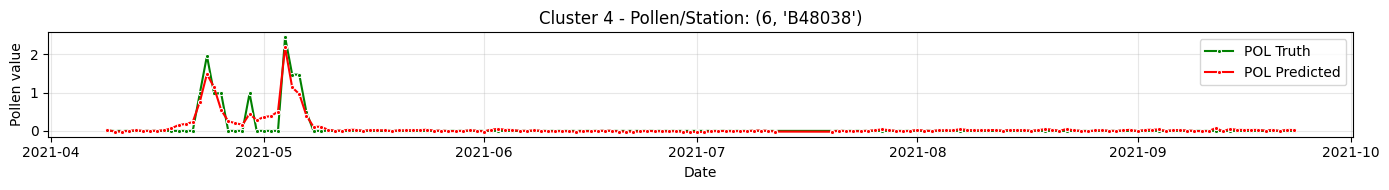

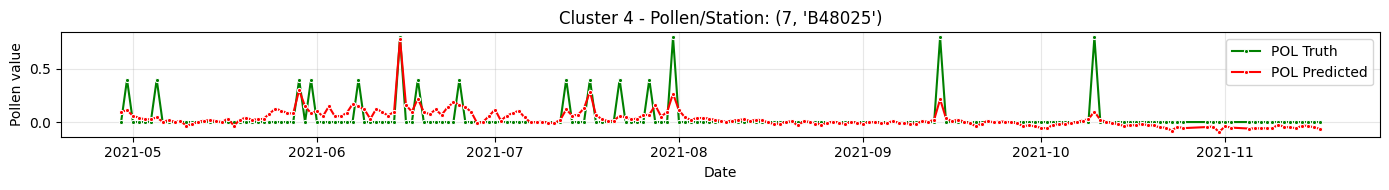

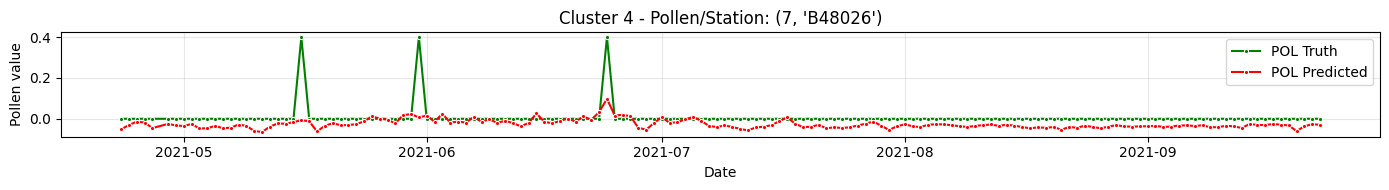

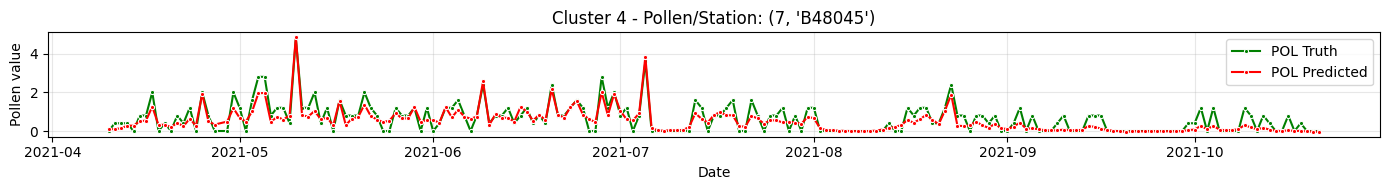

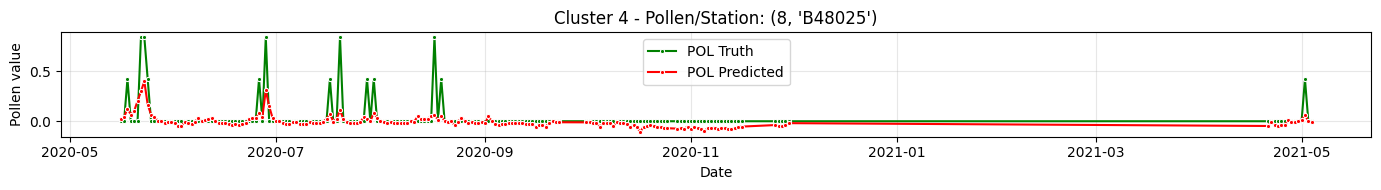

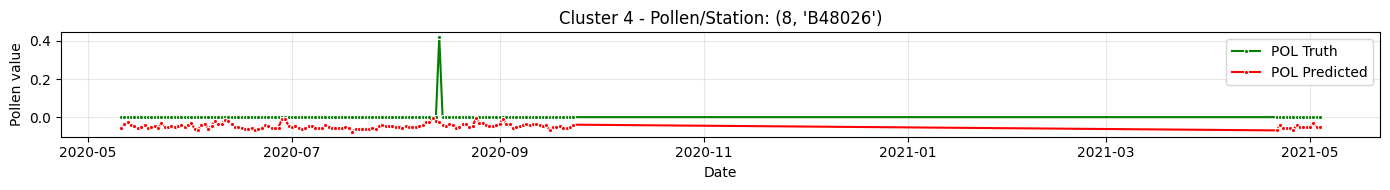

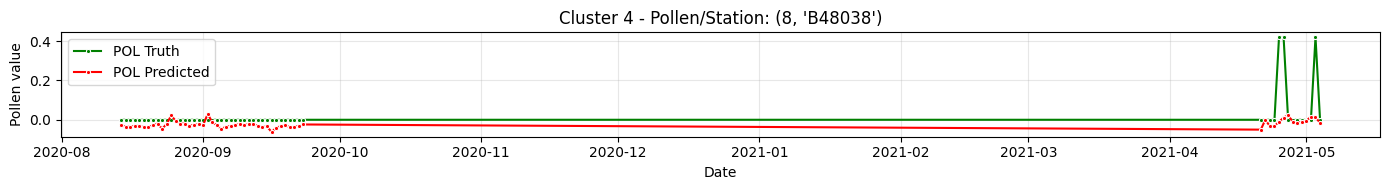

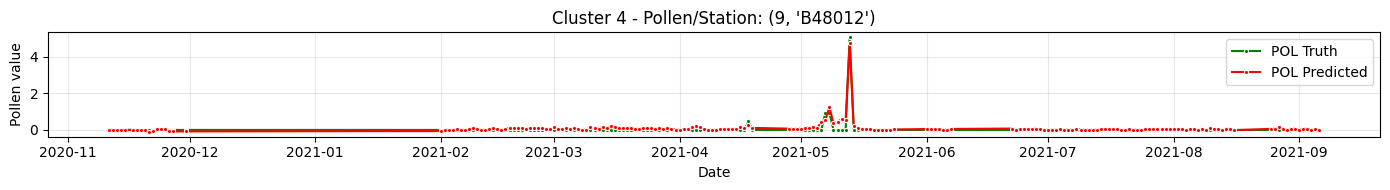

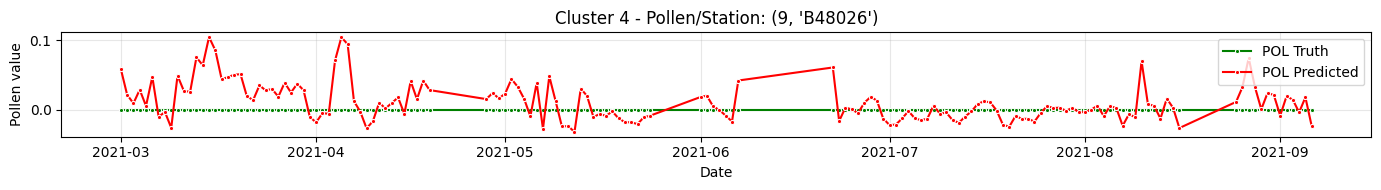

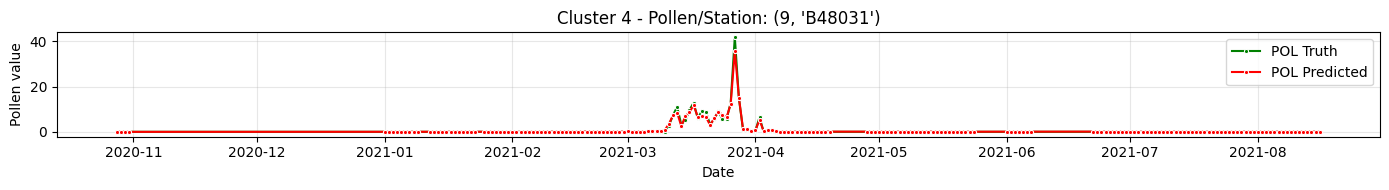

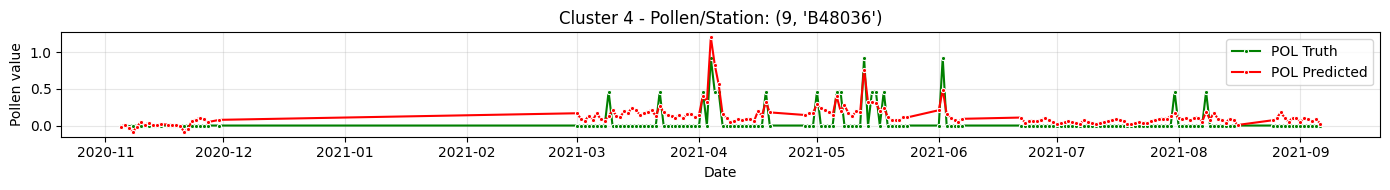

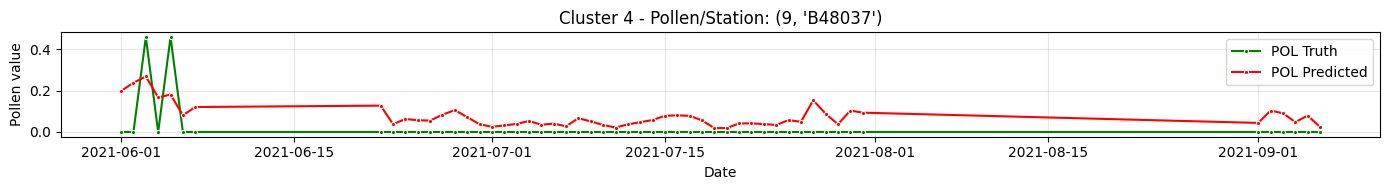

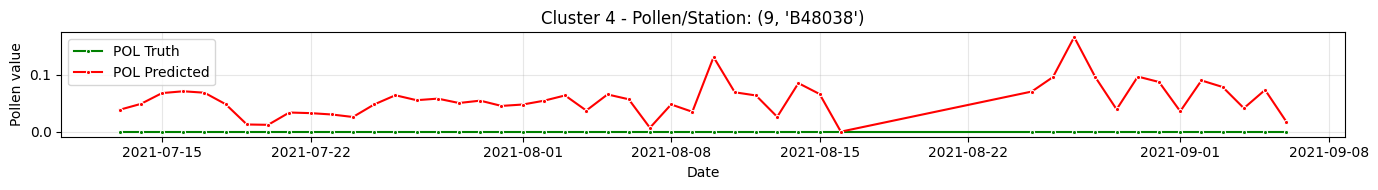

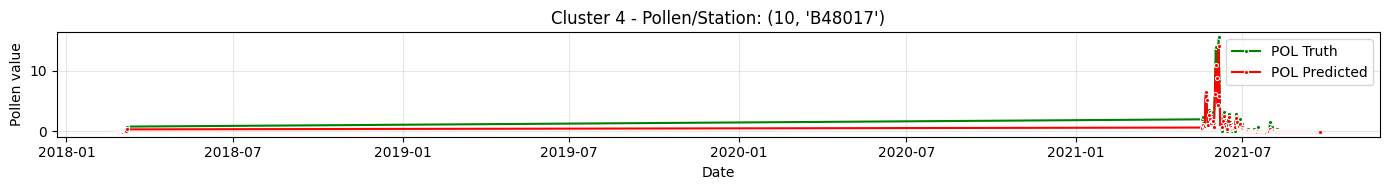

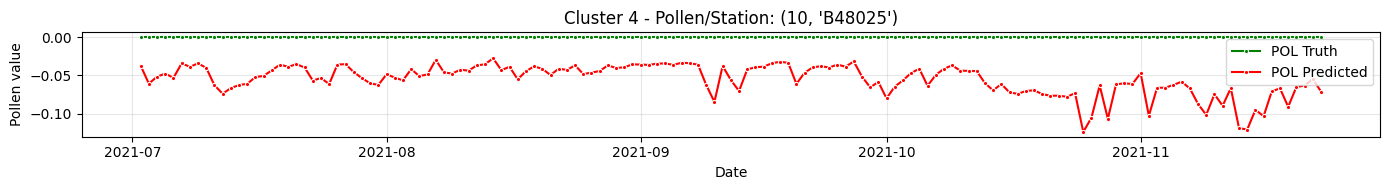

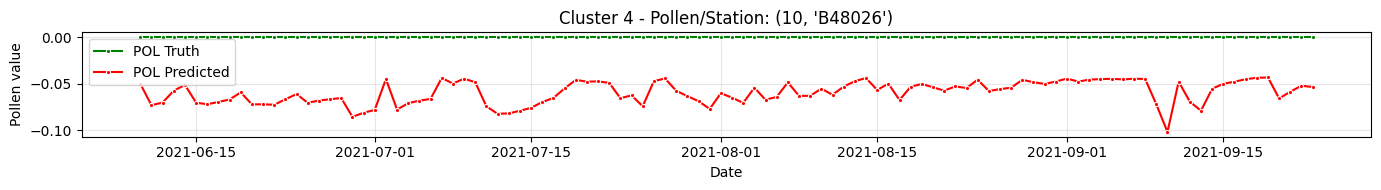

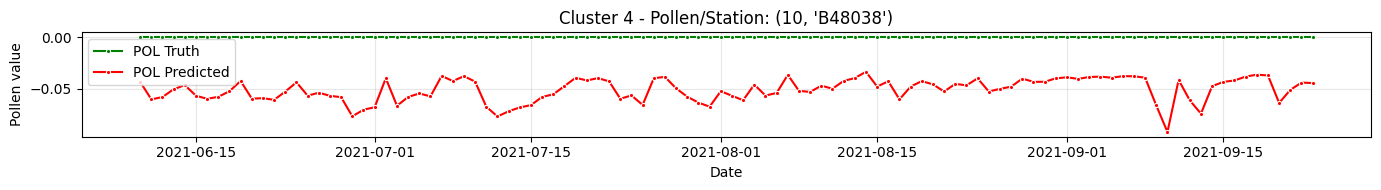

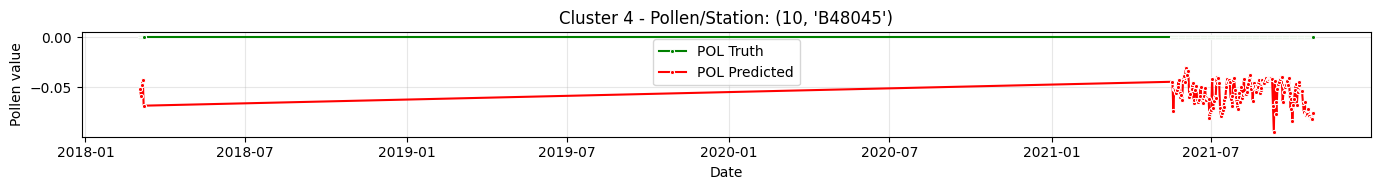

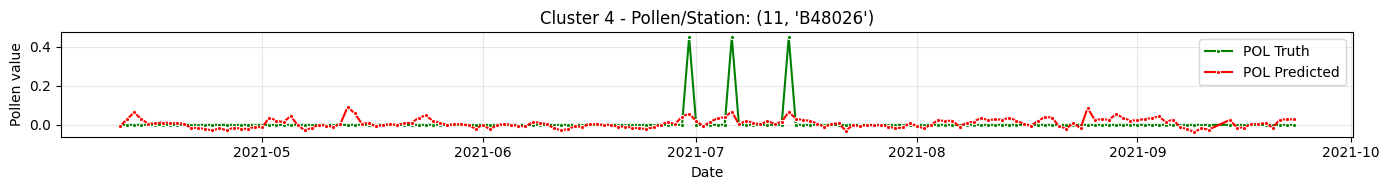

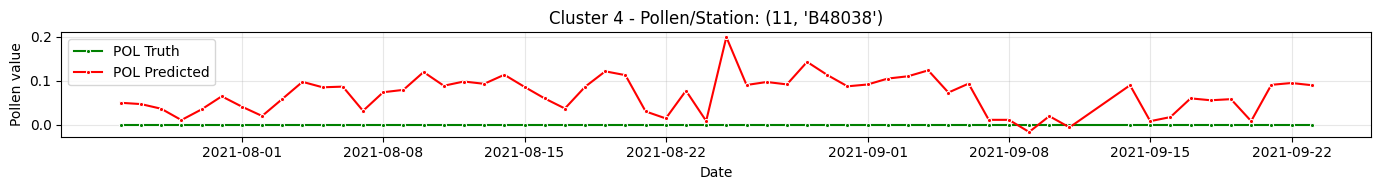

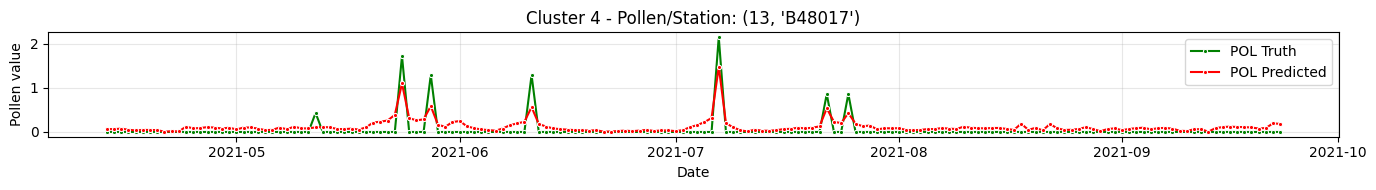

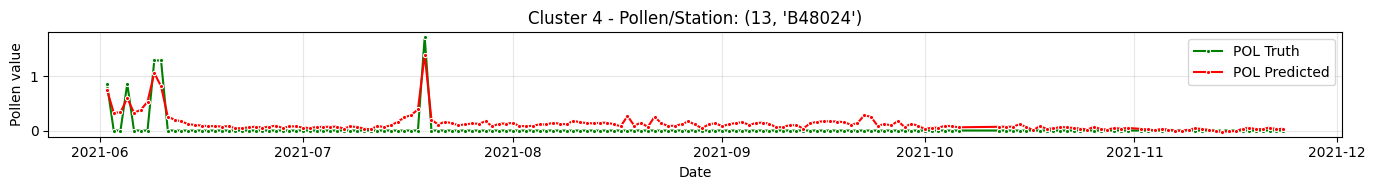

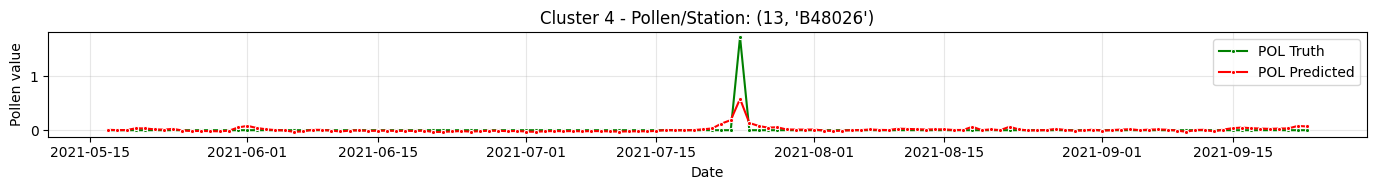

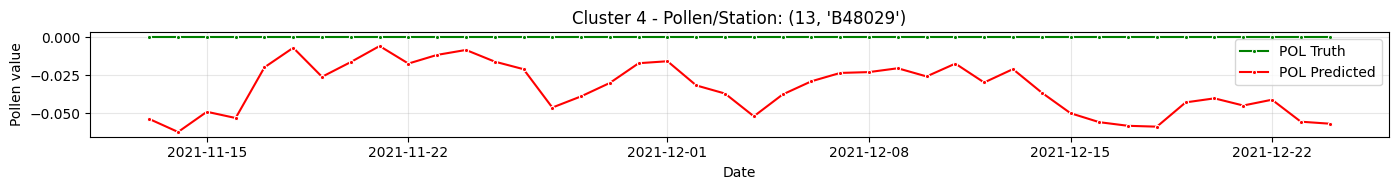

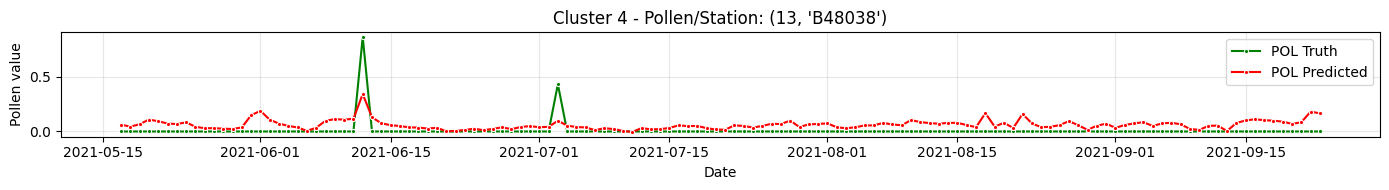

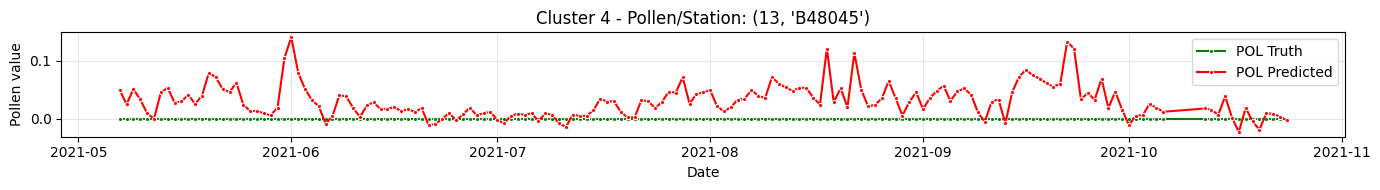

In [221]:
### Per specie/pollen prediction
specie_pollen_dataset = list(filter(lambda d: d.cluster_n == cluster_wgt.value, trainings))[0]

predictions = specie_pollen_dataset.model.predict(specie_pollen_dataset.valid_dataset, verbose=False).squeeze()
mse = specie_pollen_dataset.model.evaluate(specie_pollen_dataset.valid_dataset, verbose=False)

feat = specie_pollen_dataset.features
for group_idx, specie_group in specie_pollen_dataset.x_valid.groupby(["station_id", "pol_var_id"]):    

    species_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
        specie_group[feat],
        targets=None,
        sequence_length=window_day_size,
        batch_size=batch_size,
    )
    specie_group = specie_group[:-window_day_size+1]

    predictions = specie_pollen_dataset.model.predict(species_dataset, verbose=False).squeeze()
    mse = specie_pollen_dataset.model.evaluate(species_dataset, verbose=False)

    plt.figure(figsize=(14,2))
    plt.title(f"Cluster {specie_pollen_dataset.cluster_n} - Pollen/Station: {group_idx}")
    sns.lineplot(x=specie_group.index, y=specie_group.pol_value, marker="o", markersize=3, label="POL Truth", c="green")
    sns.lineplot(x=specie_group.index, y=predictions, marker="o", markersize=3, label="POL Predicted", c="red")
    plt.xlabel("Date")
    plt.ylabel("Pollen value")
    plt.grid(alpha=.3)
    plt.tight_layout()
    plt.show()


In [ ]:
# dati norm
# additional features